# Data Exploration and cleaning

In [2]:
import pandas as pd   
import numpy as np 
import matplotlib.pyplot as plt  
%matplotlib inline        
import seaborn as sns
import matplotlib.ticker as mtick

In [3]:
from IPython.display import display, HTML

class ColorfulLine:
    def __init__(self, border_color, background_color, height):
        self.border_color = border_color
        self.background_color = background_color
        self.height = height

    def create_line(self):
        line_style = f'border: 2px solid {self.border_color}; background-color: {self.background_color}; height: {self.height}px;'
        line_html = f'<div style="{line_style}"></div>'
        display(HTML(line_html))

# Instantiate the ColorfulLine class with desired parameters
line = ColorfulLine(border_color='#0000FF', background_color='#ADD8E6', height=5)
line.create_line()

# Importing and looking into data

In [4]:
train_data = pd.read_csv('csv_data/Training_set_values.csv')
train_target = pd.read_csv('csv_data/Training_set_labels.csv')

In [5]:
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
train_data.set_index('id',inplace=True)
train_target.set_index('id',inplace=True)

>- Afrter exploting the outer and inner merge, decided there's the same number of entries with the same id number as primary key 

In [7]:
train_data = train_data.merge(train_target,on ='id')

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

In [234]:
line.create_line()

# Cleaning and Understanding our numeric values
>- None of our numeric values are null but lets make sure that's true
>- We can see from the .describe that logtitude has some 0 values which is a line that doesn't pass by TZ
>>- Leading me to conclude 0 represents null values
>>- We can't impute logtitude so we'll omite null values for modeling
>>- It is also about 3% of our data and we can't impute 
>- num_private wasn't given any specific information from our data source
>>-  Droping it for now
>- amount_tsh measures water availability but 50% of the data is 0
>>- there's also another column that measures water availability ['quantity']
>>- Imputing will lead to skewed results, therefore dropping it 
>- Region code seems to be having false representation
>>- Arusha has code 2 and it's assigned 2 and 24 in the data
>>- Dropping it for now and using the categorical column for regions
>- District code doesn't seem to offer much insight
>>- It's a categorical feature since districts aren't numbered in TZ
>>- Repeating number for different region district code could create false narrative
>>- Hence will be dropping the column
>- Some 0's in population might be null values but we'll leave it for now
>>- The data is skewed to the right but we can use standard scaler and impute 0 values with mean
>- Constraction year can't be zero so those are null values
>>- Will be using the median value from data excluding zero to impute
>- 25% of amount_tsh, gps_height, population and construction year are 0
>>- Which makes sence if pumps were abondoned and have no entry
>>- will impute gps_height with mean value since it doesn't seem to have outliers

In [9]:
train_data.status_group.value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

In [10]:
train_data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [11]:
(train_data['longitude']==0).value_counts()

longitude
False    57588
True      1812
Name: count, dtype: int64

In [12]:
train_data.groupby(['region', 'district_code','region_code']).count().head()

amount_tsh  date_recorded  funder  \
region district_code region_code                                      
Arusha 1             2                   189            189       0   
       2             2                  1206           1206    1204   
       3             2                   109            109       0   
       5             2                   201            201     201   
       6             2                   310            310     299   

                                  gps_height  installer  longitude  latitude  \
region district_code region_code                                               
Arusha 1             2                   189          0        189       189   
       2             2                  1206       1206       1206      1206   
       3             2                   109          0        109       109   
       5             2                   201        200        201       201   
       6             2                   310        299        310       310   

                                  wpt_name  num_private  basin  ...  \
region district_code region_code                                ...   
Arusha 1             2                 189          189    189  ...   
       2             2                1206         1206   1206  ...   
       3             2                 109          109    109  ...   
       5             2                 201          201    201  ...   
       6             2                 310          310    310  ...   

                                  water_quality  quality_group  quantity  \
region district_code region_code                                           
Arusha 1             2                      189            189       189   
       2             2                     1206           1206      1206   
       3             2                      109            109       109   
       5             2                      201            201       201   
       6             2                      310            310       310   

                                  quantity_group  source  source_type  \
region district_code region_code                                        
Arusha 1             2                       189     189          189   
       2             2                      1206    1206         1206   
       3             2                       109     109          109   
       5             2                       201     201          201   
       6             2                       310     310          310   

                                  source_class  waterpoint_type  \
region district_code region_code                                  
Arusha 1             2                     189              189   
       2             2                    1206             1206   
       3             2                     109              109   
       5             2                     201              201   
       6             2                     310              310   

                                  waterpoint_type_group  status_group  
region district_code region_code                                       
Arusha 1             2                              189           189  
       2             2                             1206          1206  
       3             2                              109           109  
       5             2                              201           201  
       6             2                              310           310  

[5 rows x 37 columns]

In [13]:
# Implementing the notes above from exploring data 
from sklearn.impute import SimpleImputer

# Drop numerical columns
train_data.drop(['num_private', 'amount_tsh', 'region_code', 'district_code'], axis=1, inplace=True)

#Drop rows where longtitude is 0
train_data = train_data[train_data['longitude']!=0]

train_data['population'].replace(0, float('nan'), inplace=True)
train_data['gps_height'].replace(0, float('nan'), inplace=True)
                                 
# Impute population and gps_height since 25% of both columns is 0
population_imputer = SimpleImputer(strategy="median")
gps_imputer = SimpleImputer(strategy="mean")
train_data['population'] = population_imputer.fit_transform(train_data['population'].values.reshape(-1, 1))
train_data['gps_height'] = gps_imputer.fit_transform(train_data['gps_height'].values.reshape(-1, 1))

# Replace construction_year column with 2000
train_data.loc[train_data['construction_year'] == 0, 'construction_year'] = 2000

# Creating a new column called age for how old the schemes are from construction - current
from datetime import datetime
train_data['age_of_well']=datetime.now().year - train_data['construction_year']

In [240]:
train_data.describe()

,gps_height,longitude,latitude,population,construction_year,age_of_well
count,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000
mean,1018.860839,35.149669,-5.885572,236.542387,1997.859919,25.140081
std,503.855233,2.607428,2.809876,463.000306,10.331744,10.331744
min,-90.000000,29.607122,-11.649440,1.000000,1960.000000,10.000000
25%,860.000000,33.285100,-8.643841,90.000000,1995.000000,19.000000
50%,1018.860839,35.005943,-5.172704,150.000000,2000.000000,23.000000
75%,1332.000000,37.233712,-3.372824,230.000000,2004.000000,28.000000
max,2770.000000,40.345193,-0.998464,30500.000000,2013.000000,63.000000


In [241]:
line.create_line()

# Cleaning and Understanding the categorical values

#### The .info highlights entries that might be duplicate from the get go so we'll look into similar column names
>- scheme_management, management, & management_group
>>- They all include managment types, with managment group having better general information of managment
>>- It groups user groups, commercial, authority, other and rest as unknown
>>- Will be dropping managment_types and scheme_managment for now
>- subvillage, lga, region,& ward
>>- All these columns pertain locational information
>>- There's a lot of information to OHE in columns region, lga, ward and subvillage
>>- There's also a possibilty they're highly coorelated, i'll drop them since we've geographic locations
>- extraction_type, extraction_type_group, extraction_type_class
>>- They all have similar information on extraction type
>>- extraction_type_group And extraction_type have a lot of duplicate entries so will drop them
>>- Keeing extraction_type_class as it has more dependable data
>- payment & payment_type
>>- Both columns have the same information and will be dropping payment_type
>- quality_group, quantity, quantity_group &  water_quality
>>- Water quality and quality_group have the same information
>>- water_quality includes two of floride and salty qualirt as abondaned and not
>>- That information isn't consitant for other quality entries
>>- Will be droping water_quality and remane quality_group as water quality
>>- Quantity and quantity_group have the same information
>>- keeping quantity and droping quantity_group
>- source, source_type, source_class
>>- Source_type and source have the same information and will drop source_type for now
>- waterpoint_type & waterpoint_type_group
>>- The two columns above also contain the same information
>>- Droping waterpoint_type since it has duplicate entries
>- wpt_name & scheme_name
>>- Both seem to have names of schemes with scheme_names having multiple single letter entry
>>- These features are currently not important for this analysis and will drop for now
>- Date recorded and recorded_by aren't measures of functionality and we'll dfrop them for modeling

In [14]:
train_data.management.value_counts()

management
vwc                 39746
wug                  5556
water board          2932
wua                  2533
private operator     1970
parastatal           1696
water authority       902
other                 840
company               685
unknown               551
other - school         99
trust                  78
Name: count, dtype: int64

In [15]:
train_data.source.value_counts()

source
spring                  17006
shallow well            15499
machine dbh             10826
river                    9612
rainwater harvesting     2218
hand dtw                  873
dam                       649
lake                      639
other                     202
unknown                    64
Name: count, dtype: int64

In [16]:
train_data.groupby(['source', 'source_type', 'source_class']).count().head(50)

,,,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,...,payment,payment_type,water_quality,quality_group,quantity,quantity_group,waterpoint_type,waterpoint_type_group,status_group,age_of_well
source,source_type,source_class,,,,,,,,,,,,,,,,,,,,,
dam,dam,surface,649,640,649,639,649,649,649,649,649,649,...,649,649,649,649,649,649,649,649,649,649
hand dtw,borehole,groundwater,873,867,873,867,873,873,873,873,873,873,...,873,873,873,873,873,873,873,873,873,873
lake,river/lake,surface,639,637,639,637,639,639,639,639,638,639,...,639,639,639,639,639,639,639,639,639,639
machine dbh,borehole,groundwater,10826,10002,10826,9998,10826,10826,10825,10826,10600,10826,...,10826,10826,10826,10826,10826,10826,10826,10826,10826,10826
other,other,unknown,202,194,202,194,202,202,202,202,202,202,...,202,202,202,202,202,202,202,202,202,202
rainwater harvesting,rainwater harvesting,surface,2218,2023,2218,2021,2218,2218,2218,2218,2216,2218,...,2218,2218,2218,2218,2218,2218,2218,2218,2218,2218
river,river/lake,surface,9612,8715,9612,8721,9612,9612,9612,9612,9612,9612,...,9612,9612,9612,9612,9612,9612,9612,9612,9612,9612
shallow well,shallow well,groundwater,15499,14983,15499,14969,15499,15499,15499,15499,15492,15499,...,15499,15499,15499,15499,15499,15499,15499,15499,15499,15499
spring,spring,groundwater,17006,15858,17006,15860,17006,17006,17005,17006,16871,17006,...,17006,17006,17006,17006,17006,17006,17006,17006,17006,17006


In [17]:
train_data.groupby(['management_group', 'source_type', 'management']).count().head()

date_recorded  funder  \
management_group source_type management                                
commercial       borehole    company                      52      41   
                             private operator            759     748   
                             trust                        25      25   
                             water authority             381     377   
                 dam         company                       2       2   

                                               gps_height  installer  \
management_group source_type management                                
commercial       borehole    company                   52         41   
                             private operator         759        748   
                             trust                     25         25   
                             water authority          381        377   
                 dam         company                    2          2   

                                               longitude  latitude  wpt_name  \
management_group source_type management                                        
commercial       borehole    company                  52        52        52   
                             private operator        759       759       759   
                             trust                    25        25        25   
                             water authority         381       381       381   
                 dam         company                   2         2         2   

                                               basin  subvillage  region  ...  \
management_group source_type management                                   ...   
commercial       borehole    company              52          52      52  ...   
                             private operator    759         720     759  ...   
                             trust                25          25      25  ...   
                             water authority     381         372     381  ...   
                 dam         company               2           2       2  ...   

                                               water_quality  quality_group  \
management_group source_type management                                       
commercial       borehole    company                      52             52   
                             private operator            759            759   
                             trust                        25             25   
                             water authority             381            381   
                 dam         company                       2              2   

                                               quantity  quantity_group  \
management_group source_type management                                   
commercial       borehole    company                 52              52   
                             private operator       759             759   
                             trust                   25              25   
                             water authority        381             381   
                 dam         company                  2               2   

                                               source  source_class  \
management_group source_type management                               
commercial       borehole    company               52            52   
                             private operator     759           759   
                             trust                 25            25   
                             water authority      381           381   
                 dam         company                2             2   

                                               waterpoint_type  \
management_group source_type management                          
commercial       borehole    company                        52   
                             private operator              759   
                             trust                          25   


In [18]:
train_data.groupby(['extraction_type_class','extraction_type', 'extraction_type_group']).count().head()

date_recorded  \
extraction_type_class extraction_type extraction_type_group                  
gravity               gravity         gravity                        26696   
handpump              afridev         afridev                         1659   
                      india mark ii   india mark ii                   2284   
                      india mark iii  india mark iii                    91   
                      nira/tanira     nira/tanira                     7361   

                                                             funder  \
extraction_type_class extraction_type extraction_type_group           
gravity               gravity         gravity                 24624   
handpump              afridev         afridev                  1557   
                      india mark ii   india mark ii            2243   
                      india mark iii  india mark iii             91   
                      nira/tanira     nira/tanira              7109   

                                                             gps_height  \
extraction_type_class extraction_type extraction_type_group               
gravity               gravity         gravity                     26696   
handpump              afridev         afridev                      1659   
                      india mark ii   india mark ii                2284   
                      india mark iii  india mark iii                 91   
                      nira/tanira     nira/tanira                  7361   

                                                             installer  \
extraction_type_class extraction_type extraction_type_group              
gravity               gravity         gravity                    24636   
handpump              afridev         afridev                     1554   
                      india mark ii   india mark ii               2243   
                      india mark iii  india mark iii                91   
                      nira/tanira     nira/tanira                 7095   

                                                             longitude  \
extraction_type_class extraction_type extraction_type_group              
gravity               gravity         gravity                    26696   
handpump              afridev         afridev                     1659   
                      india mark ii   india mark ii               2284   
                      india mark iii  india mark iii                91   
                      nira/tanira     nira/tanira                 7361   

                                                             latitude  \
extraction_type_class extraction_type extraction_type_group             
gravity               gravity         gravity                   26696   
handpump              afridev         afridev                    1659   
                      india mark ii   india mark ii              2284   
                      india mark iii  india mark iii               91   
                      nira/tanira     nira/tanira                7361   

                                                             wpt_name  basin  \
extraction_type_class extraction_type extraction_type_group                    
gravity               gravity         gravity                   26695  26696   
handpump              afridev         afridev                    1659   1659   
                      india mark ii   india mark ii              2284   2284   
                      india mark iii  india mark iii               91     91   
                      nira/tanira     nira/tanira                7361   7361   

                                                             subvillage  \
extraction_type_class extraction_type extraction_type_group               
gravity               gravity         gravity                     26562   
handpump              afridev         afridev                      1659   
                      india mark ii   india mark ii                2284   
    

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57588 entries, 69572 to 26348
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          57588 non-null  object 
 1   funder                 53964 non-null  object 
 2   gps_height             57588 non-null  float64
 3   installer              53952 non-null  object 
 4   longitude              57588 non-null  float64
 5   latitude               57588 non-null  float64
 6   wpt_name               57586 non-null  object 
 7   basin                  57588 non-null  object 
 8   subvillage             57217 non-null  object 
 9   region                 57588 non-null  object 
 10  lga                    57588 non-null  object 
 11  ward                   57588 non-null  object 
 12  population             57588 non-null  float64
 13  public_meeting         54612 non-null  object 
 14  recorded_by            57588 non-null  object 
 15  sch

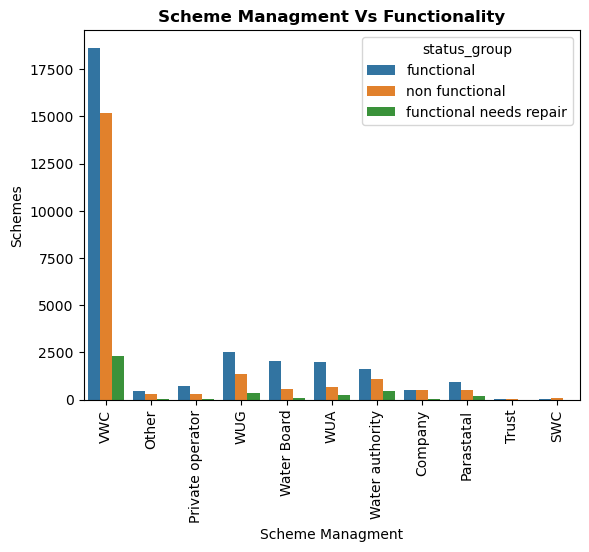

In [20]:
ax = sns.countplot(x='scheme_management', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Scheme Managment');
plt.ylabel('Schemes');
plt.title('Scheme Managment Vs Functionality',fontsize=12, fontweight='bold');

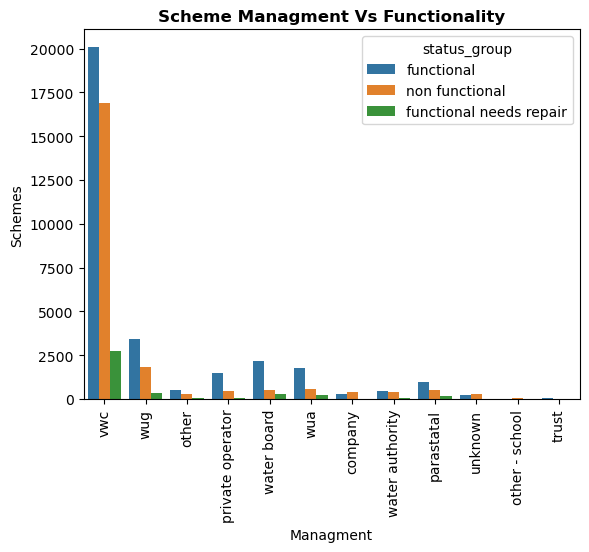

In [21]:
ax = sns.countplot(x='management', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Managment');
plt.ylabel('Schemes');
plt.title('Scheme Managment Vs Functionality',fontsize=12, fontweight='bold');

In [22]:
# Drop categorical columns
train_data.drop(['scheme_management', 'management', 'subvillage', 'lga', 'ward', 'extraction_type_group', 
                 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 
                 'waterpoint_type', 'wpt_name', 'scheme_name', 'date_recorded', 'recorded_by', 'region'], axis=1, inplace=True)

# Rename quality_group column to become water_quality
train_data.rename(columns={'quality_group': 'water_quality'}, inplace=True)

In [251]:
line.create_line()

#### We'll now look into null values of categorical columns
>- There's 3637 missing from funder
>- 3655 from installer, 3056 from permit
>- And 3334 from public_meeting
>- replacing null values with unknown for now

#### Imputing and grouping 
>- There's a long list of funders and installers
>- To make our OHE easier, we'll mention top 5 and group the rest as others
>- Substantial amount of the water schemes have permit
>- We'll impute missing values with most_frequent to not lose data

In [23]:
train_data.isna().sum()

funder                   3624
gps_height                  0
installer                3636
longitude                   0
latitude                    0
basin                       0
population                  0
public_meeting           2976
permit                   3056
construction_year           0
extraction_type_class       0
management_group            0
payment                     0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
status_group                0
age_of_well                 0
dtype: int64

In [24]:
#filling null values with Unknown
train_data.funder = train_data.funder.fillna('unknown')
train_data.installer = train_data.installer.fillna('unknown')
train_data.public_meeting = train_data.public_meeting.fillna('unknown')
train_data.permit =train_data.permit.fillna('unknown')

In [25]:
train_data.isna().sum()

funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
population               0
public_meeting           0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment                  0
water_quality            0
quantity                 0
source                   0
source_class             0
waterpoint_type_group    0
status_group             0
age_of_well              0
dtype: int64

#### Funder and installer information
>- there is 777, '0' values in both columns and 1 'o'

In [26]:
(train_data['funder'] =='0').value_counts()

funder
False    56811
True       777
Name: count, dtype: int64

In [27]:
(train_data['installer'] =="O").value_counts()

installer
False    57587
True         1
Name: count, dtype: int64

In [28]:
# Replacing '0' and 'O' values with unknown for now
train_data['funder'].replace(to_replace= '0', value= 'unknown', inplace=True)
train_data['funder'].replace(to_replace= 'O', value= 'unknown', inplace=True)
train_data['installer'].replace(to_replace= '0', value= 'unknown', inplace=True)
train_data['installer'].replace(to_replace= 'O', value= 'unknown', inplace=True)

In [29]:
train_data.groupby(['installer','funder']).count().head(70)

gps_height  longitude  latitude  basin  \
installer funder                                                           
-         Government Of Tanzania           2          2         2      2   
          Kalebejo Parish                  1          1         1      1   
A.D.B     Hesawa                           1          1         1      1   
AAR       Aar                              4          4         4      4   
ABASIA    Abasia                          29         29        29     29   
...                                      ...        ...       ...    ...   
AMREF     In Memoria Di Albeto             1          1         1      1   
          Incerto                          1          1         1      1   
          Louise Elucas Sala               1          1         1      1   
          Private Individual               1          1         1      1   
          Redekop Digloria                 1          1         1      1   

                                  population  public_meeting  permit  \
installer funder                                                       
-         Government Of Tanzania           2               2       2   
          Kalebejo Parish                  1               1       1   
A.D.B     Hesawa                           1               1       1   
AAR       Aar                              4               4       4   
ABASIA    Abasia                          29              29      29   
...                                      ...             ...     ...   
AMREF     In Memoria Di Albeto             1               1       1   
          Incerto                          1               1       1   
          Louise Elucas Sala               1               1       1   
          Private Individual               1               1       1   
          Redekop Digloria                 1               1       1   

                                  construction_year  extraction_type_class  \
installer funder                                                             
-         Government Of Tanzania                  2                      2   
          Kalebejo Parish                         1                      1   
A.D.B     Hesawa                                  1                      1   
AAR       Aar                                     4                      4   
ABASIA    Abasia                                 29                     29   
...                                             ...                    ...   
AMREF     In Memoria Di Albeto                    1                      1   
          Incerto                                 1                      1   
          Louise Elucas Sala                      1                      1   
          Private Individual                      1                      1   
          Redekop Digloria                        1                      1   

                                  management_group  payment  water_quality  \
installer funder                                                             
-         Government Of Tanzania                 2        2              2   
          Kalebejo Parish                        1        1              1   
A.D.B     Hesawa                                 1        1              1   
AAR       Aar                                    4        4              4   
ABASIA    Abasia                                29       29             29   
...                                            ...      ...            ...   
AMREF     In Memoria Di Albeto                   1        1              1   
          Incerto                                1        1              1   
          Louise Elucas Sala                     1        1              1   
          Private Individual                     1        1              1   
          Redekop Digloria                       1        1              1   

                                  quantity  source  source_class  \
installer 

In [30]:
train_data.installer.value_counts().head()

installer
DWE           16255
unknown        4415
Government     1670
RWE            1181
Commu          1060
Name: count, dtype: int64

In [31]:
train_data.funder.value_counts().head()

funder
Government Of Tanzania    8842
unknown                   4402
Danida                    3114
Hesawa                    1914
World Bank                1345
Name: count, dtype: int64

# Cleaning the categorical columns I decided to keep for modeling

In [32]:
train_data

,funder,gps_height,installer,longitude,latitude,basin,population,public_meeting,permit,construction_year,extraction_type_class,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type_group,status_group,age_of_well
id,,,,,,,,,,,,,,,,,,,,
69572,Roman,1390.000000,Roman,34.938093,-9.856322,Lake Nyasa,109.0,True,False,1999,gravity,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,functional,24
8776,Grumeti,1399.000000,GRUMETI,34.698766,-2.147466,Lake Victoria,280.0,unknown,True,2010,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,13
34310,Lottery Club,686.000000,World vision,37.460664,-3.821329,Pangani,250.0,True,True,2009,gravity,user-group,pay per bucket,good,enough,dam,surface,communal standpipe,functional,14
67743,Unicef,263.000000,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,58.0,True,True,1986,submersible,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe,non functional,37
19728,Action In A,1018.860839,Artisan,31.130847,-1.825359,Lake Victoria,150.0,True,True,2000,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,Germany Republi,1210.000000,CES,37.169807,-3.253847,Pangani,125.0,True,True,1999,gravity,user-group,pay per bucket,good,enough,spring,groundwater,communal standpipe,functional,24
27263,Cefa-njombe,1212.000000,Cefa,35.249991,-9.070629,Rufiji,56.0,True,True,1996,gravity,user-group,pay annually,good,enough,river,surface,communal standpipe,functional,27
37057,unknown,1018.860839,unknown,34.017087,-8.750434,Rufiji,150.0,True,False,2000,handpump,user-group,pay monthly,fluoride,enough,machine dbh,groundwater,hand pump,functional,23


In [261]:
#replace unknow in binary columns with the most frequent 
most_frequent_permit = train_data.permit.mode()[0]
train_data.permit = train_data.permit.replace('unknown', most_frequent_permit)

most_frequent_meeting = train_data.public_meeting.mode()[0]
train_data.public_meeting = train_data.public_meeting.replace('unknown', most_frequent_meeting)

In [262]:
# Impute missing values in 'funder' and 'installer' columns
imputer = SimpleImputer(strategy='most_frequent')
train_data[['funder', 'installer']] = imputer.fit_transform(train_data[['funder', 'installer']])

# Group 'funder' and 'installer' columns
top_funders = train_data['funder'].value_counts().nlargest(5).index
train_data.loc[~train_data['funder'].isin(top_funders), 'funder'] = 'Others'

top_installers = train_data['installer'].value_counts().nlargest(5).index
train_data.loc[~train_data['installer'].isin(top_installers), 'installer'] = 'Others'

In [263]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57588 entries, 69572 to 26348
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 57588 non-null  object 
 1   gps_height             57588 non-null  float64
 2   installer              57588 non-null  object 
 3   longitude              57588 non-null  float64
 4   latitude               57588 non-null  float64
 5   basin                  57588 non-null  object 
 6   population             57588 non-null  float64
 7   public_meeting         57588 non-null  bool   
 8   permit                 57588 non-null  bool   
 9   construction_year      57588 non-null  int64  
 10  extraction_type_class  57588 non-null  object 
 11  management_group       57588 non-null  object 
 12  payment                57588 non-null  object 
 13  water_quality          57588 non-null  object 
 14  quantity               57588 non-null  object 
 15  sou

In [264]:
train_data.installer.value_counts().head()

installer
Others        33007
DWE           16255
unknown        4415
Government     1670
RWE            1181
Name: count, dtype: int64

In [265]:
train_data['installer'].replace(to_replace='Commu', value= 'Community', inplace=True)

In [266]:
line.create_line()

# There's no longer null columns
#### Will now explore the data and it's relationship with target values

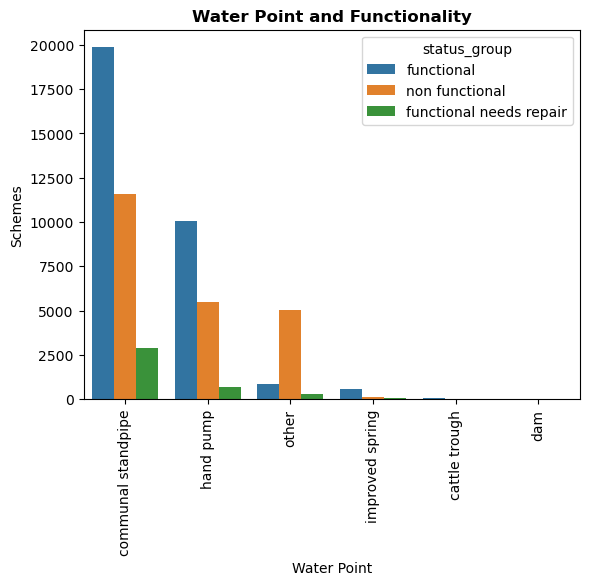

In [267]:
plt.figure("Water Point Types And Functionality")
ax = sns.countplot(x='waterpoint_type_group', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Water Point');
plt.ylabel('Schemes');
plt.title('Water Point and Functionality',fontsize=12, fontweight='bold');

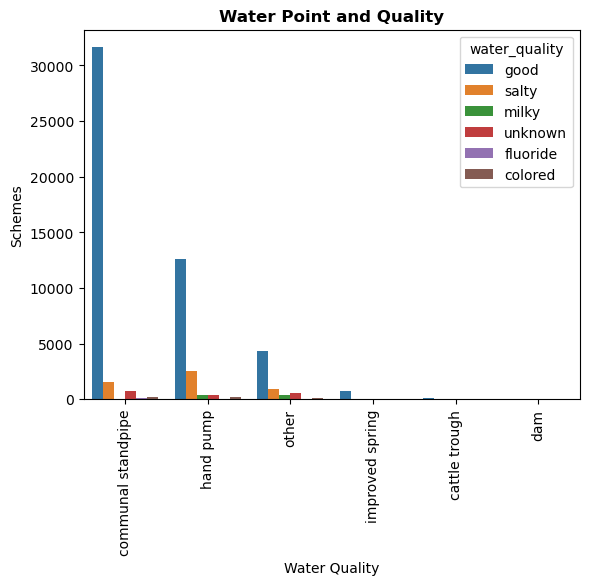

In [268]:
plt.figure("Water Point Types And Functionality")
ax = sns.countplot(x='waterpoint_type_group', hue="water_quality", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Water Quality');
plt.ylabel('Schemes');
plt.title('Water Point and Quality',fontsize=12, fontweight='bold');

[Text(0, 0, 'good'),
 Text(1, 0, 'salty'),
 Text(2, 0, 'milky'),
 Text(3, 0, 'unknown'),
 Text(4, 0, 'fluoride'),
 Text(5, 0, 'colored')]

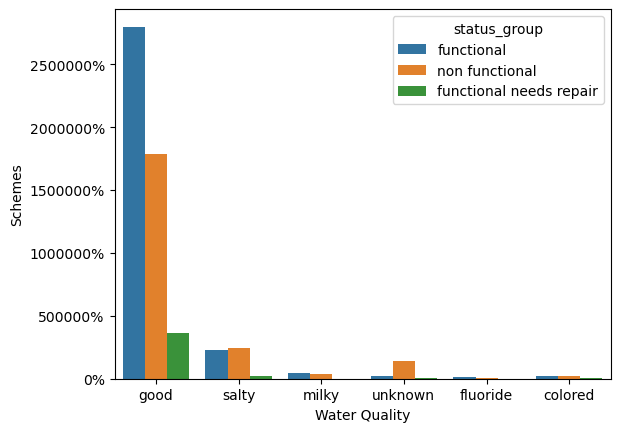

In [269]:
plt.figure("Water Quality And Functionality")
ax = sns.countplot(x='water_quality', hue="status_group", data=train_data)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Water Quality');
plt.ylabel('Schemes');
ax.set_xticklabels(ax.get_xticklabels())

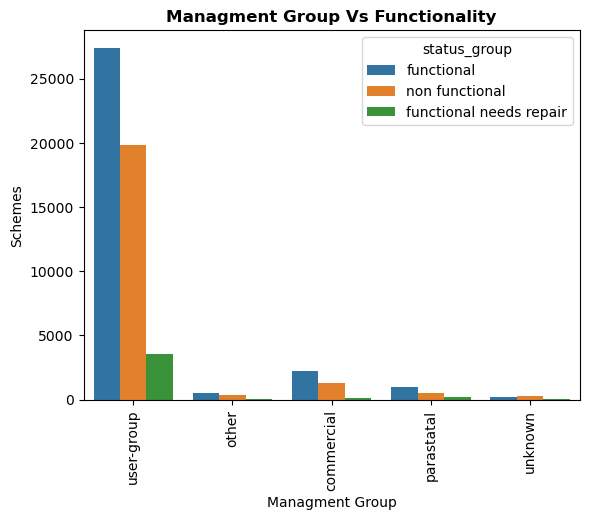

In [270]:
ax = sns.countplot(x='management_group', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Managment Group');
plt.ylabel('Schemes');
plt.title('Managment Group Vs Functionality',fontsize=12, fontweight='bold');

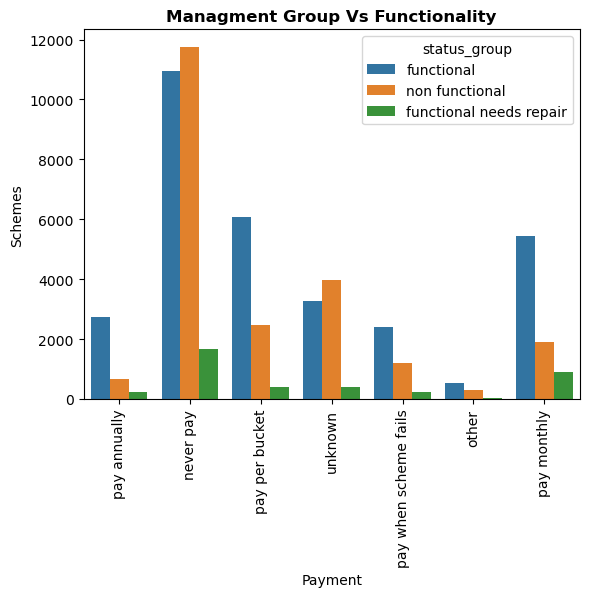

In [271]:
ax = sns.countplot(x='payment', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Payment');
plt.ylabel('Schemes');
plt.title('Managment Group Vs Functionality',fontsize=12, fontweight='bold');

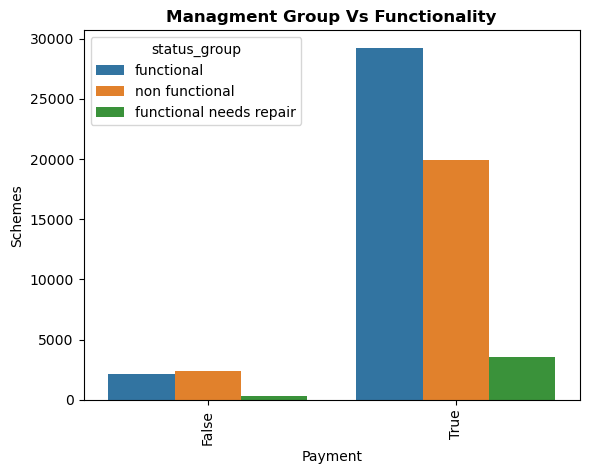

In [272]:
ax = sns.countplot(x='public_meeting', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Payment');
plt.ylabel('Schemes');
plt.title('Managment Group Vs Functionality',fontsize=12, fontweight='bold');

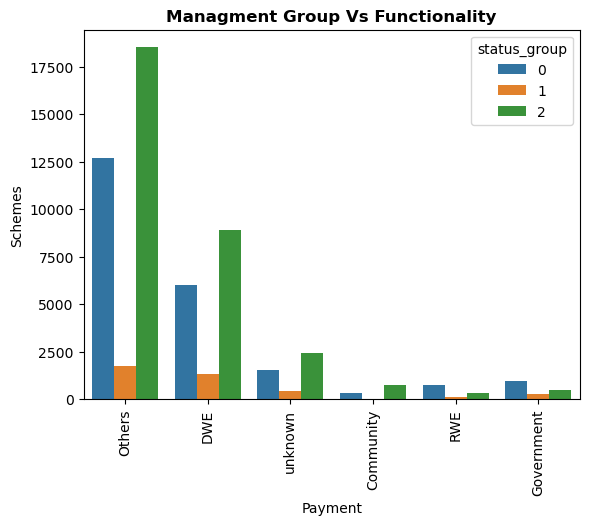

In [283]:
ax = sns.countplot(x='installer', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Payment');
plt.ylabel('Schemes');
plt.title('Managment Group Vs Functionality',fontsize=12, fontweight='bold');

In [273]:
line.create_line()

# Grouping target as Functional and Needs Repair for Modeling Purposes
>- 1 representing Functional water pumps
>- 0 representing those that need repair

In [274]:
train_data.status_group.value_counts(normalize=True)

status_group
functional                 0.545061
non functional             0.386678
functional needs repair    0.068261
Name: proportion, dtype: float64

In [275]:
vals_to_replace = {'functional':2, 'functional needs repair':1,
                   'non functional':0}

train_data['status_group']  = train_data.status_group.replace(vals_to_replace)

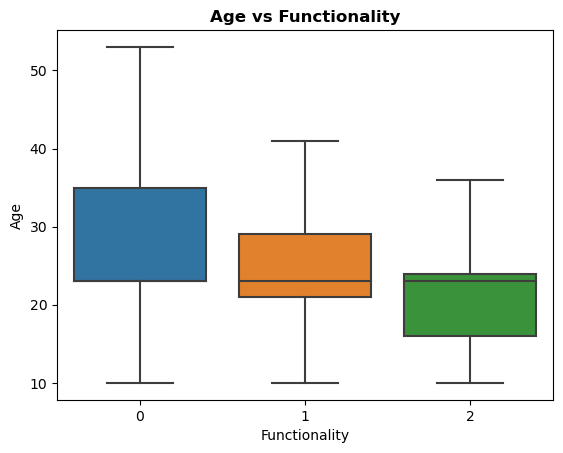

In [276]:
sns.boxplot(x='status_group',y='age_of_well', data=train_data, showfliers=False)
plt.xlabel('Functionality');
plt.ylabel('Age');
plt.title('Age vs Functionality',fontsize=12, fontweight='bold');

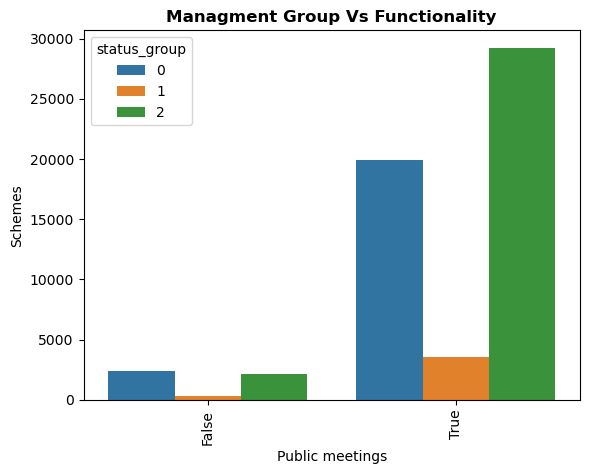

In [277]:
ax = sns.countplot(x='public_meeting', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Public meetings');
plt.ylabel('Schemes');
plt.title('Managment Group Vs Functionality',fontsize=12, fontweight='bold');

In [278]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57588 entries, 69572 to 26348
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 57588 non-null  object 
 1   gps_height             57588 non-null  float64
 2   installer              57588 non-null  object 
 3   longitude              57588 non-null  float64
 4   latitude               57588 non-null  float64
 5   basin                  57588 non-null  object 
 6   population             57588 non-null  float64
 7   public_meeting         57588 non-null  bool   
 8   permit                 57588 non-null  bool   
 9   construction_year      57588 non-null  int64  
 10  extraction_type_class  57588 non-null  object 
 11  management_group       57588 non-null  object 
 12  payment                57588 non-null  object 
 13  water_quality          57588 non-null  object 
 14  quantity               57588 non-null  object 
 15  sou

In [284]:
train_data

,funder,gps_height,installer,longitude,latitude,basin,population,public_meeting,permit,construction_year,extraction_type_class,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type_group,status_group,age_of_well
id,,,,,,,,,,,,,,,,,,,,
69572,Others,1390.000000,Others,34.938093,-9.856322,Lake Nyasa,109.0,True,False,1999,gravity,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,2,24
8776,Others,1399.000000,Others,34.698766,-2.147466,Lake Victoria,280.0,True,True,2010,gravity,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2,13
34310,Others,686.000000,Others,37.460664,-3.821329,Pangani,250.0,True,True,2009,gravity,user-group,pay per bucket,good,enough,dam,surface,communal standpipe,2,14
67743,Others,263.000000,Others,38.486161,-11.155298,Ruvuma / Southern Coast,58.0,True,True,1986,submersible,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe,0,37
19728,Others,1018.860839,Others,31.130847,-1.825359,Lake Victoria,150.0,True,True,2000,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,Others,1210.000000,Others,37.169807,-3.253847,Pangani,125.0,True,True,1999,gravity,user-group,pay per bucket,good,enough,spring,groundwater,communal standpipe,2,24
27263,Others,1212.000000,Others,35.249991,-9.070629,Rufiji,56.0,True,True,1996,gravity,user-group,pay annually,good,enough,river,surface,communal standpipe,2,27
37057,unknown,1018.860839,unknown,34.017087,-8.750434,Rufiji,150.0,True,False,2000,handpump,user-group,pay monthly,fluoride,enough,machine dbh,groundwater,hand pump,2,23


In [279]:
line.create_line()

### Saving data as csv for modeling notebook

In [281]:
train_data.to_csv('clean_data.csv')